In this project, comments for a restaurant analyzed and classification method applied.

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud
import nltk
from nltk.tokenize import sent_tokenize,word_tokenize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df=pd.read_csv("restaurant.csv")
df.sample(5)

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
8892,3081915,PBDxjD5c8gQT6jz-it2rmQ,CP4UKGInRmJQ7VgoZEDR3A,RESDUcs7fIiihp38-d6_6g,5,0,0,0,"Amazing Buffett, good variety of food. Definit...",2019-03-18 22:03:44
833,2435218,MJLLejgXV8tHYgWY75QbKg,Ry2eEdDFbB3jCd-puLq0bg,RESDUcs7fIiihp38-d6_6g,5,5,2,2,"This is a food library, not a Buffet since the...",2015-07-06 05:18:35
5602,2793231,MK-oEE5Afgzii0ILz1rtzA,SeeyLanTQASHqytvBHURHg,RESDUcs7fIiihp38-d6_6g,5,3,0,5,Just got back from Vegas from my bachelorette ...,2014-08-05 16:50:29
5851,2810664,H9RYr1HC_2Yy4mEOw52ziQ,lG5bbfErPfWYQJ7dhDpCOg,RESDUcs7fIiihp38-d6_6g,4,0,0,0,"For a buffet place, this place is the king. A...",2014-08-21 13:11:44
5784,2805445,qnvPEGjs4onk9MpreL8-Vg,SQ7u5RYPPoi5kFb72ugKgg,RESDUcs7fIiihp38-d6_6g,5,1,0,0,I admit I was a bit shocked when the cashier c...,2013-04-10 04:25:10


In [3]:
df=df[['stars','text']]

In [4]:
df.shape

(10417, 2)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10417 entries, 0 to 10416
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   stars   10417 non-null  int64 
 1   text    10417 non-null  object
dtypes: int64(1), object(1)
memory usage: 162.9+ KB


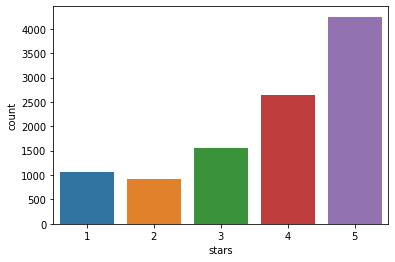

In [6]:
sns.countplot(df['stars']);

In [7]:
df['stars'].value_counts()

5    4247
4    2636
3    1561
1    1056
2     917
Name: stars, dtype: int64

In [8]:
df["text"]=df["text"].str.lower()
df["text"]=df["text"].str.replace("[^\w\s]","") # replacing punctuation marks 
df["text"]=df["text"].str.replace("\d+","") # replacing digits
df["text"]=df["text"].str.replace("\n"," ").replace("\r","") # replacing \n (end of line) and \r (enter)

In [9]:
df.sample(5)

,stars,text
7861,5,probably the best buffet in las vegas cant spe...
8559,3,ive heard a lot about this buffet and when i w...
4381,5,went for brunch simply amazing got here at o...
9527,5,excellent service great vast selection but wit...
5295,5,this place is expensive but totally worth it t...


In [10]:
df.loc[df['stars']==3,"sentiment"]="neutral"
df.loc[df['stars']<3,"sentiment"]="negative"
df.loc[df['stars']>3,"sentiment"]="positive"

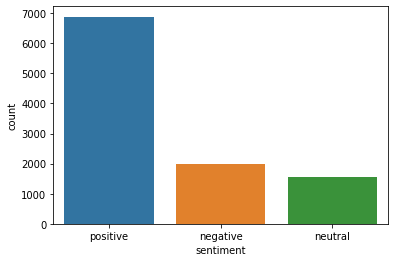

In [12]:
sns.countplot(df.sentiment);

In [13]:
#!pip install textblob
from langdetect import detect_langs

In [14]:
# detecting which language is used in comments
language = [detect_langs(i) for i in df.text]
languages = [str(i[0]).split(':')[0] for i in language]
df['language'] = languages

In [15]:
df.language.value_counts()

en       10373
es          10
zh-cn        7
ja           7
ko           6
fr           4
de           4
da           2
sw           1
ca           1
sk           1
pt           1
Name: language, dtype: int64

In [17]:
# only english comments has been taken
df=df[df['language']=='en']
df.reset_index(drop=True,inplace=True)

In [18]:
x,y=df['text'],df['sentiment']

In [19]:
def tokenize_test(vect,x,y):
    from sklearn.naive_bayes import GaussianNB
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier #yüklemek için !pip install xgboost kullandım
    
    from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
    from sklearn.metrics import confusion_matrix,classification_report
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=60)
    
    print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
    
    g=GaussianNB()
    b=BernoulliNB()
    SVC=SVC()
    KN=KNeighborsClassifier()
    D=DecisionTreeClassifier()
    R=RandomForestClassifier()
    Log=LogisticRegression()
    XGBC=XGBClassifier()
    
    algos=[g,b,SVC]
    algo_names=['GaussianNB','BernoulliNB','SVC']
    accuracy_scored=[]    
        
    x_train_dtm=vect.fit_transform(x_train).toarray()
    x_test_dtm=vect.transform(x_test).toarray()
    
    for item in algos:
        item.fit(x_train_dtm,y_train)
        accuracy_scored.append(accuracy_score(y_test,item.predict(x_test_dtm)))
    result=pd.DataFrame(accuracy_scored,columns=['accuracy_score'],index=algo_names)
    result.accuracy_score=accuracy_scored
    return result.sort_values('accuracy_score',ascending=False)

In [20]:
vect=CountVectorizer()
tokenize_test(vect,x,y)

(8298,) (2075,) (8298,) (2075,)


,accuracy_score
SVC,0.775422
BernoulliNB,0.694458
GaussianNB,0.397590


In [22]:
from PIL import Image
def wc(data,bgcolor):
    mask = np.array(Image.open("cloud.png"))
    wc=WordCloud(background_color=bgcolor, width=800, height=400,mask=mask,max_words=100).generate(' '.join(data))
    plt.figure( figsize=(20,10) )
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

In [23]:
negative_data=df[df['sentiment']=="negative"]['text']
positive_data=df[df['sentiment']=="positive"]['text']
neutral_data=df[df['sentiment']=="neutral"]['text']

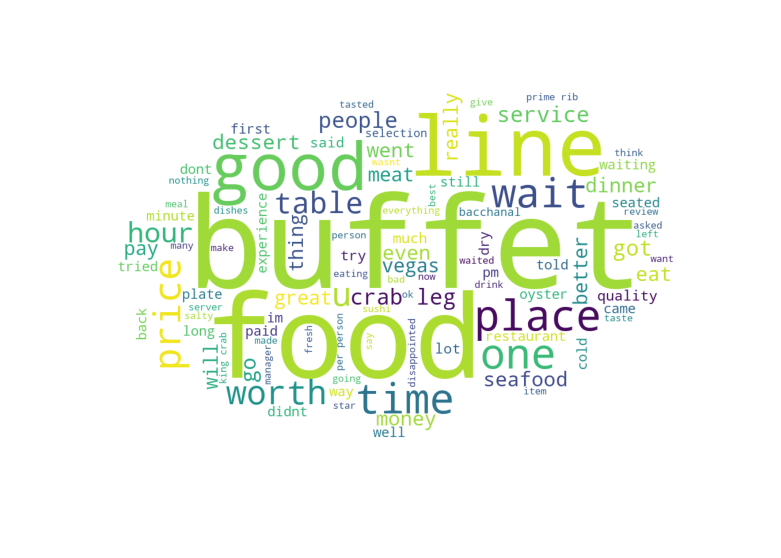

In [24]:
wc(negative_data,'white')

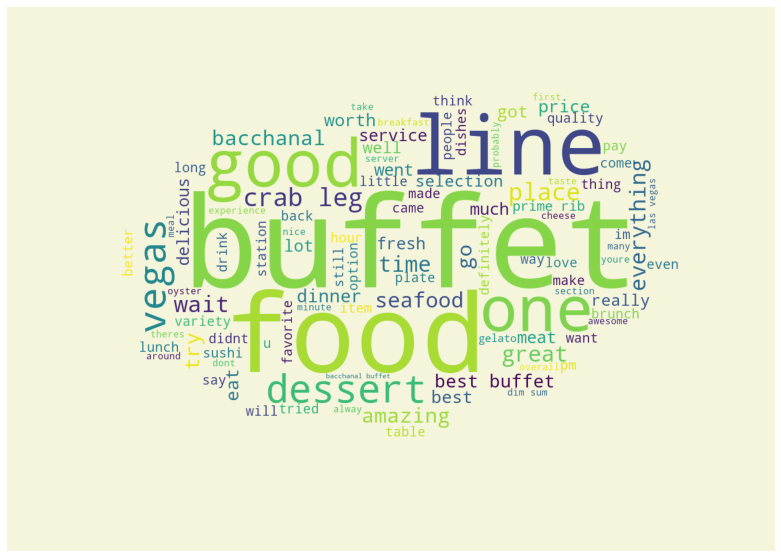

In [25]:
wc(positive_data,'beige')

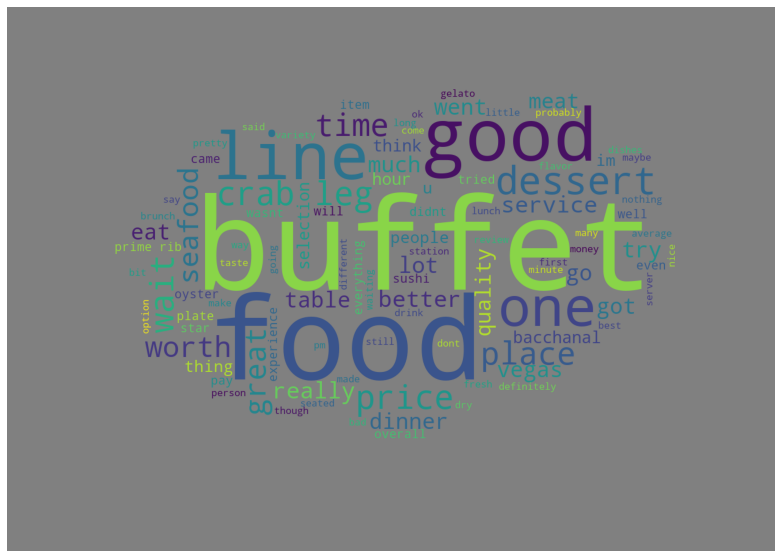

In [26]:
wc(neutral_data,'gray')

Sentiment analys done using df["text"] column (customer comments). 

Positive, negative and neutral data visualized using wordcloud.